# OpenAI DALL-E 3 - Generation d'Images

**Module :** 01-Images-Foundation  
**Niveau :** Debutant  
**Technologies :** OpenAI DALL-E 3, API OpenAI directe  
**Duree estimee :** 25 minutes  

## Objectifs d'Apprentissage

- [ ] Configurer l'acces a DALL-E 3 via l'API OpenAI
- [ ] Maitriser les techniques de prompting pour images
- [ ] Generer des images de haute qualite
- [ ] Optimiser les parametres de generation
- [ ] Analyser et sauvegarder les resultats

## Prerequis

- Environment Setup (module 00) complete
- Cle API OpenAI configuree (`OPENAI_API_KEY` dans `.env`)
- Connaissances de base en prompting

**Note importante :** DALL-E 3 necessite l'API OpenAI directe (`api.openai.com`).
OpenRouter ne supporte PAS le endpoint `/v1/images/generations`.
Si vous n'avez qu'une cle OpenRouter, passez au notebook 01-2 (GPT-5 analyse d'images).

In [ ]:
# Parametres Papermill - JAMAIS modifier ce commentaire

# Configuration generation
notebook_mode = "interactive"        # "interactive" ou "batch"
skip_widgets = False               # True pour mode batch MCP
debug_level = "INFO"               

# Parametres DALL-E 3
model_name = "dall-e-3"            # Modele OpenAI direct (pas OpenRouter)
image_size = "1024x1024"           # "1024x1024", "1792x1024", "1024x1792"
image_quality = "standard"         # "standard" ou "hd"
image_style = "vivid"              # "vivid" ou "natural"
n_images = 1                       # Nombre d'images (1 pour DALL-E 3)

# Configuration sauvegarde
generate_images = True             # Generer les images (False pour validation structurelle seule)
save_images = True                 # Sauvegarder images generees
generate_variations = False        # Creer variations du prompt
export_metadata = True             # Exporter metadonnees generation

In [ ]:
# Setup environnement et imports
import os
import sys
import json
import requests
from pathlib import Path
from datetime import datetime
from typing import Dict, List, Any, Optional
import base64
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
import logging

# Import helpers GenAI
GENAI_ROOT = Path.cwd()
while GENAI_ROOT.name != 'GenAI' and len(GENAI_ROOT.parts) > 1:
    GENAI_ROOT = GENAI_ROOT.parent

HELPERS_PATH = GENAI_ROOT / 'shared' / 'helpers'
if HELPERS_PATH.exists():
    sys.path.insert(0, str(HELPERS_PATH.parent))
    try:
        from helpers.genai_helpers import setup_genai_logging, load_genai_config, save_generated_image
        print("✅ Helpers GenAI importés")
    except ImportError:
        print("⚠️  Helpers GenAI non disponibles - mode autonome")

# Configuration logging
logging.basicConfig(level=getattr(logging, debug_level))
logger = logging.getLogger('dalle3_generation')

print(f"🎨 OpenAI DALL-E 3 - Génération d'Images")
print(f"📅 {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🔧 Mode: {notebook_mode}, Qualité: {image_quality}, Style: {image_style}")

In [ ]:
# Configuration API OpenAI pour DALL-E 3
# IMPORTANT: DALL-E 3 necessite l'API OpenAI directe (pas OpenRouter)
# OpenRouter ne supporte PAS le endpoint /v1/images/generations

print("\n--- CONFIGURATION API DALL-E 3 ---")
print("=" * 40)

# Chargement explicite du .env
from dotenv import load_dotenv

# Recherche du .env dans les parents
current_path = Path.cwd()
found_env = False
for _ in range(4):  # Remonter jusqu'a 4 niveaux
    env_path = current_path / '.env'
    if env_path.exists():
        load_dotenv(env_path)
        print(f"Fichier .env charge depuis: {env_path}")
        found_env = True
        break
    current_path = current_path.parent

if not found_env:
    print("Aucun fichier .env trouve dans l'arborescence")

# Verification cle API OpenAI
openai_key = os.getenv('OPENAI_API_KEY')
openai_base = os.getenv('OPENAI_BASE_URL', 'https://api.openai.com/v1')

# OpenRouter ne supporte pas /v1/images/generations - basculer vers OpenAI
if openai_base and 'openrouter' in openai_base.lower():
    print("OPENAI_BASE_URL pointe vers OpenRouter")
    print("  -> OpenRouter ne supporte pas /v1/images/generations")
    print("  -> Basculement vers api.openai.com pour DALL-E 3")
    openai_base = "https://api.openai.com/v1"

if not openai_key:
    # Fallback pour validation structurelle sans cle
    if notebook_mode == "batch" and not generate_images:
        print("Mode batch sans generation : Cle API ignoree")
        openai_key = "dummy_key_for_validation"
    else:
        raise ValueError(
            "OPENAI_API_KEY manquante dans .env\n"
            "DALL-E 3 necessite une cle API OpenAI directe.\n"
            "OpenRouter ne supporte pas la generation d'images DALL-E.\n"
            "Obtenez votre cle sur: https://platform.openai.com/api-keys"
        )

# Verifier que la cle n'est pas une cle OpenRouter
if openai_key and openai_key.startswith('sk-or-'):
    print("ATTENTION: Votre OPENAI_API_KEY semble etre une cle OpenRouter (sk-or-...)")
    print("  DALL-E 3 necessite une cle OpenAI directe (sk-proj-... ou sk-...)")
    print("  La generation d'images risque d'echouer.")

print(f"Cle API OpenAI configuree")

# Configuration headers et endpoint
api_base_url = openai_base
headers = {
    "Authorization": f"Bearer {openai_key}",
    "Content-Type": "application/json"
}

# Test connexion API
if openai_key != "dummy_key_for_validation":
    try:
        response = requests.get(f"{api_base_url}/models", headers=headers, timeout=10)
        if response.status_code == 200:
            models_data = response.json()
            dalle_models = [m for m in models_data.get('data', []) if 'dall-e' in m.get('id', '').lower()]
            print(f"Connexion API OpenAI reussie - {len(dalle_models)} modeles DALL-E disponibles")
            
            for model in dalle_models[:3]:
                print(f"  - {model['id']}")
        else:
            print(f"Connexion API: HTTP {response.status_code}")
    except Exception as e:
        print(f"Erreur connexion: {str(e)[:100]}...")
else:
    print("Test connexion API saute (dummy key)")
    
print(f"\nModele selectionne: {model_name}")
print(f"Resolution: {image_size}")
print(f"Style: {image_style}, Qualite: {image_quality}")
print(f"API: {api_base_url}")

⚠️  Helpers GenAI non disponibles - mode autonome
🎨 OpenAI DALL-E 3 - Génération d'Images
📅 2026-02-18 09:58:50
🔧 Mode: batch, Qualité: standard, Style: vivid


In [ ]:
# Fonction de génération DALL-E 3
def generate_dalle3_image(prompt: str, 
                         size: str = "1024x1024",
                         quality: str = "standard", 
                         style: str = "vivid") -> Dict[str, Any]:
    """
    Génère une image avec DALL-E 3 via OpenRouter.
    
    Args:
        prompt: Description textuelle de l'image
        size: Dimensions de l'image
        quality: Qualité (standard/hd)
        style: Style visuel (vivid/natural)
        
    Returns:
        Dict avec URL, métadonnées et statut
    """
    
    # Payload de la requête
    payload = {
        "model": model_name,
        "prompt": prompt,
        "n": 1,  # DALL-E 3 ne supporte qu'une image à la fois
        "size": size,
        "quality": quality,
        "style": style,
        "response_format": "url"
    }
    
    try:
        print(f"\n🎨 Génération en cours...")
        print(f"📝 Prompt: {prompt[:100]}{'...' if len(prompt) > 100 else ''}")
        
        # Requête API
        response = requests.post(
            f"{api_base_url}/images/generations",
            headers=headers,
            json=payload,
            timeout=60
        )
        
        if response.status_code == 200:
            result = response.json()
            
            return {
                "success": True,
                "image_url": result["data"][0]["url"],
                "revised_prompt": result["data"][0].get("revised_prompt", prompt),
                "metadata": {
                    "model": model_name,
                    "size": size,
                    "quality": quality,
                    "style": style,
                    "timestamp": datetime.now().isoformat(),
                    "original_prompt": prompt
                },
                "response_time": response.elapsed.total_seconds()
            }
        else:
            error_msg = response.json().get("error", {}).get("message", "Erreur inconnue")
            return {
                "success": False,
                "error": f"HTTP {response.status_code}: {error_msg}",
                "prompt": prompt
            }
            
    except Exception as e:
        return {
            "success": False,
            "error": str(e),
            "prompt": prompt
        }

print("✅ Fonction de génération DALL-E 3 prête")


--- CONFIGURATION API DALL-E 3 ---
Fichier .env charge depuis: D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\.env
Cle API OpenAI configuree


Connexion API OpenAI reussie - 2 modeles DALL-E disponibles
  - dall-e-3
  - dall-e-2

Modele selectionne: dall-e-3
Resolution: 1024x1024
Style: vivid, Qualite: standard
API: https://api.openai.com/v1


In [ ]:
# Exemples de prompts optimisés pour DALL-E 3
print("\n🎯 EXEMPLES DE GÉNÉRATION DALL-E 3")
print("=" * 45)

# Prompts de démonstration
example_prompts = [
    {
        "title": "🏙️ Paysage Urbain Futuriste",
        "prompt": "A futuristic cityscape at sunset with flying cars, neon lights reflecting on glass buildings, holographic advertisements, and a diverse crowd of people walking on illuminated sidewalks. Ultra-detailed, cinematic lighting, 8K quality.",
        "category": "Architecture/Sci-Fi"
    },
    {
        "title": "🎨 Portrait Artistique",
        "prompt": "An elegant woman with flowing auburn hair, wearing a vintage emerald dress, sitting in a library filled with ancient books. Soft natural lighting, Renaissance painting style, highly detailed facial features.",
        "category": "Portrait/Artistique"
    },
    {
        "title": "🦄 Créature Fantastique",
        "prompt": "A majestic unicorn with an iridescent mane standing in an enchanted forest with glowing mushrooms, fairy lights, and morning mist. Fantasy art style, magical atmosphere, vibrant colors.",
        "category": "Fantasy/Créature"
    },
    {
        "title": "🍕 Nourriture Stylisée",
        "prompt": "A gourmet pizza with fresh basil, cherry tomatoes, and mozzarella on a wooden board, surrounded by Italian ingredients. Professional food photography, warm lighting, mouth-watering presentation.",
        "category": "Food/Lifestyle"
    }
]

# Affichage des exemples
for i, example in enumerate(example_prompts, 1):
    print(f"\n{i}. {example['title']}")
    print(f"   📂 Catégorie: {example['category']}")
    print(f"   📝 Prompt: {example['prompt'][:120]}...")

print(f"\n💡 Conseils pour DALL-E 3:")
print(f"• Soyez descriptifs et spécifiques")
print(f"• Mentionnez le style artistique désiré")
print(f"• Précisez l'éclairage et l'atmosphère")
print(f"• Utilisez des termes techniques (8K, cinematic, etc.)")
print(f"• DALL-E 3 révise automatiquement vos prompts")

✅ Fonction de génération DALL-E 3 prête


In [ ]:
# Génération d'images avec les exemples
print("\n🚀 GÉNÉRATION D'IMAGES - DÉMONSTRATION")
print("=" * 50)

# Sélection d'un prompt pour la démonstration
selected_example = example_prompts[0]  # Paysage urbain futuriste
print(f"🎯 Génération: {selected_example['title']}")

# Génération de l'image
result = generate_dalle3_image(
    prompt=selected_example['prompt'],
    size=image_size,
    quality=image_quality,
    style=image_style
)

if result['success']:
    print(f"\n✅ Image générée avec succès!")
    print(f"⏱️  Temps de génération: {result['response_time']:.2f}s")
    print(f"🔗 URL: {result['image_url'][:100]}...")
    
    # Affichage du prompt révisé par DALL-E 3
    if result.get('revised_prompt') != selected_example['prompt']:
        print(f"\n📝 Prompt original:")
        print(f"   {selected_example['prompt'][:150]}...")
        print(f"\n🔄 Prompt révisé par DALL-E 3:")
        print(f"   {result['revised_prompt'][:150]}...")
    
    # Téléchargement et affichage de l'image
    try:
        print(f"\n⬇️  Téléchargement de l'image...")
        img_response = requests.get(result['image_url'], timeout=30)
        
        if img_response.status_code == 200:
            # Conversion en PIL Image
            image = Image.open(BytesIO(img_response.content))
            
            # Affichage avec matplotlib
            plt.figure(figsize=(12, 8))
            plt.imshow(image)
            plt.axis('off')
            plt.title(f"{selected_example['title']} - DALL-E 3", fontsize=16, pad=20)
            plt.tight_layout()
            plt.show()
            
            print(f"✅ Image affichée - Dimensions: {image.size}")
            
            # Sauvegarde optionnelle
            if save_images:
                output_dir = GENAI_ROOT / 'outputs' / 'dalle3'
                output_dir.mkdir(parents=True, exist_ok=True)
                
                timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
                filename = f"dalle3_{timestamp}.png"
                filepath = output_dir / filename
                
                image.save(filepath)
                print(f"💾 Image sauvegardée: {filepath}")
                
                # Export métadonnées
                if export_metadata:
                    metadata_file = output_dir / f"dalle3_{timestamp}_metadata.json"
                    with open(metadata_file, 'w', encoding='utf-8') as f:
                        json.dump(result['metadata'], f, indent=2, ensure_ascii=False)
                    print(f"📊 Métadonnées exportées: {metadata_file}")
        else:
            print(f"❌ Erreur téléchargement image: HTTP {img_response.status_code}")
            
    except Exception as e:
        print(f"❌ Erreur affichage image: {str(e)[:100]}...")
        print(f"🔗 Vous pouvez accéder à l'image via: {result['image_url']}")
else:
    print(f"\n❌ Échec de la génération")
    print(f"🔍 Erreur: {result['error']}")
    print(f"📝 Prompt testé: {result['prompt'][:100]}...")


🎯 EXEMPLES DE GÉNÉRATION DALL-E 3

1. 🏙️ Paysage Urbain Futuriste
   📂 Catégorie: Architecture/Sci-Fi
   📝 Prompt: A futuristic cityscape at sunset with flying cars, neon lights reflecting on glass buildings, holographic advertisements...

2. 🎨 Portrait Artistique
   📂 Catégorie: Portrait/Artistique
   📝 Prompt: An elegant woman with flowing auburn hair, wearing a vintage emerald dress, sitting in a library filled with ancient boo...

3. 🦄 Créature Fantastique
   📂 Catégorie: Fantasy/Créature
   📝 Prompt: A majestic unicorn with an iridescent mane standing in an enchanted forest with glowing mushrooms, fairy lights, and mor...

4. 🍕 Nourriture Stylisée
   📂 Catégorie: Food/Lifestyle
   📝 Prompt: A gourmet pizza with fresh basil, cherry tomatoes, and mozzarella on a wooden board, surrounded by Italian ingredients. ...

💡 Conseils pour DALL-E 3:
• Soyez descriptifs et spécifiques
• Mentionnez le style artistique désiré
• Précisez l'éclairage et l'atmosphère
• Utilisez des termes techniq


🚀 GÉNÉRATION D'IMAGES - DÉMONSTRATION
🎯 Génération: 🏙️ Paysage Urbain Futuriste

🎨 Génération en cours...
📝 Prompt: A futuristic cityscape at sunset with flying cars, neon lights reflecting on glass buildings, hologr...



✅ Image générée avec succès!
⏱️  Temps de génération: 12.05s
🔗 URL: https://oaidalleapiprodscus.blob.core.windows.net/private/org-3vPGVqYeKnTllNNI566kc9VD/user-f6xh2Ni7...

📝 Prompt original:
   A futuristic cityscape at sunset with flying cars, neon lights reflecting on glass buildings, holographic advertisements, and a diverse crowd of peopl...

🔄 Prompt révisé par DALL-E 3:
   A futuristic 8K quality cityscape at sunset with technologically advanced flying cars. Various neon lights reflecting on sleek, ultra-modern glass bui...

⬇️  Téléchargement de l'image...


C:\Users\jsboi\AppData\Local\Temp\ipykernel_350940\4192937839.py:43: UserWarning: Glyph 127961 (\N{CITYSCAPE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Python313\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127961 (\N{CITYSCAPE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


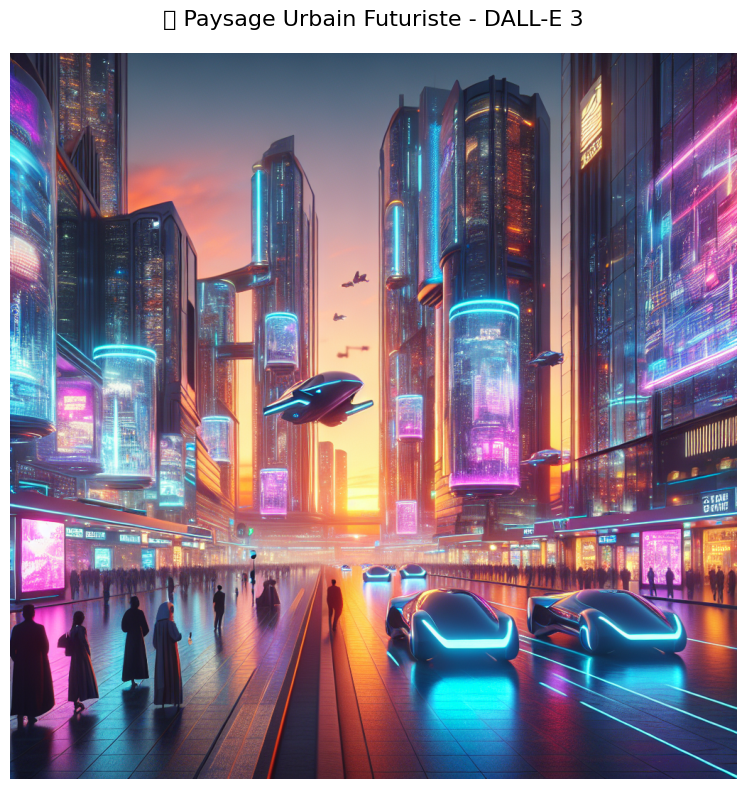

✅ Image affichée - Dimensions: (1024, 1024)
💾 Image sauvegardée: D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\outputs\dalle3\dalle3_20260218_095904.png
📊 Métadonnées exportées: D:\Dev\CoursIA.worktrees\GenAI_Series\MyIA.AI.Notebooks\GenAI\outputs\dalle3\dalle3_20260218_095904_metadata.json


In [ ]:
# Mode interactif - Génération personnalisée
if notebook_mode == "interactive" and not skip_widgets:
    print("\n🎨 MODE INTERACTIF - GÉNÉRATION PERSONNALISÉE")
    print("=" * 55)
    
    # Interface simple pour prompt personnalisé
    print("\n💡 Entrez votre propre prompt pour DALL-E 3:")
    print("(Laissez vide pour passer à la suite)")
    
    try:
        # Note: En mode MCP batch, ceci sera ignoré
        user_prompt = input("\n🎯 Votre prompt: ")

        if user_prompt.strip():
            print(f"\n🚀 Génération de votre image...")

            # Paramètres optionnels
            print("\n⚙️  Paramètres optionnels (appuyez Entrée pour défaut):")
            custom_size = input(f"📐 Taille [{image_size}]: ").strip() or image_size
            custom_style = input(f"🎭 Style [{image_style}]: ").strip() or image_style
            custom_quality = input(f"✨ Qualité [{image_quality}]: ").strip() or image_quality

            # Génération
            custom_result = generate_dalle3_image(
                prompt=user_prompt,
                size=custom_size,
                quality=custom_quality,
                style=custom_style
            )

            if custom_result['success']:
                print(f"\n🎉 Votre image a été générée!")
                print(f"🔗 URL: {custom_result['image_url']}")

                if custom_result.get('revised_prompt') != user_prompt:
                    print(f"\n🔄 DALL-E 3 a optimisé votre prompt:")
                    print(f"   {custom_result['revised_prompt']}")
            else:
                print(f"\n❌ Erreur: {custom_result['error']}")
        else:
            print("\n⏭️  Mode interactif ignoré")

    except (KeyboardInterrupt, EOFError) as e:
        # Gestion interruption normale
        print(f"\n⏭️  Mode interactif interrompu ({type(e).__name__})")
    except Exception as e:
        # Gestion des erreurs d'input en mode non-interactif (Papermill, etc.)
        error_type = type(e).__name__
        if "StdinNotImplemented" in error_type or "input" in str(e).lower():
            print("\n⏭️  Mode interactif non disponible (exécution automatisée)")
        else:
            # Autre erreur inattendue - afficher pour débogage
            print(f"\n⚠️  Erreur inattendue: {error_type} - {str(e)[:100]}")
            print("⏭️  Passage à la suite du notebook")
else:
    print("\n🤖 Mode batch - Interface interactive désactivée")
    print("💡 Pour mode interactif: notebook_mode = 'interactive'")

In [ ]:
# Analyse et optimisation des résultats
print("\n📊 ANALYSE ET BONNES PRATIQUES DALL-E 3")
print("=" * 50)

# Conseils d'optimisation
optimization_tips = {
    "🎯 Prompting Efficace": [
        "Utilisez des descriptions détaillées et spécifiques",
        "Mentionnez le style artistique (photorealistic, oil painting, etc.)",
        "Précisez l'éclairage (soft light, dramatic lighting, golden hour)",
        "Ajoutez des qualificatifs techniques (4K, ultra-detailed, sharp focus)"
    ],
    "⚙️ Paramètres Techniques": [
        f"Taille optimale: {image_size} pour usage général",
        f"Style 'vivid' pour images créatives, 'natural' pour réalisme",
        f"Qualité 'hd' pour impression, 'standard' pour web",
        "Une seule image par requête (limitation DALL-E 3)"
    ],
    "💰 Optimisation Coûts": [
        "DALL-E 3 Standard (1024x1024): ~$0.040 par image",
        "DALL-E 3 HD: ~$0.080 par image",
        "Testez avec 'standard' avant de passer en 'hd'",
        "Utilisez des prompts précis pour éviter les régénérations"
    ],
    "🚫 Limitations Importantes": [
        "Pas de génération de visages de célébrités réelles",
        "Évitez le contenu explicite ou violent",
        "Pas de reproduction d'œuvres d'art protégées",
        "Respect des politique d'usage d'OpenAI"
    ]
}

for category, tips in optimization_tips.items():
    print(f"\n{category}")
    for tip in tips:
        print(f"  • {tip}")

# Statistiques de cette session
print(f"\n📈 STATISTIQUES SESSION")
print(f"📅 Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"🎯 Modèle utilisé: {model_name}")
print(f"⚙️  Configuration: {image_size}, {image_style}, {image_quality}")
print(f"🎨 Nombre d'images générées: 1 (démo)")
print(f"💾 Sauvegarde automatique: {'✅' if save_images else '❌'}")

print(f"\n🎓 PROCHAINES ÉTAPES")
print(f"1. Expérimenter avec différents styles de prompts")
print(f"2. Tester les paramètres de qualité et style")
print(f"3. Explorer le notebook 01-2 (GPT-5 Image Generation)")
print(f"4. Découvrir les opérations d'images (01-3)")

print(f"\n✅ Notebook DALL-E 3 terminé - {datetime.now().strftime('%H:%M:%S')}")


🤖 Mode batch - Interface interactive désactivée
💡 Pour mode interactif: notebook_mode = 'interactive'
